# Logistic Regression

This is the first notebook for a tutorial on "Practical Bayesian Modeling with PyMC"

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurveyDataPyMC/blob/main/notebooks/01_logistic_regression.ipynb)

In [1]:
# Get utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/SurveyDataPyMC/raw/main/notebooks/utils.py")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

from utils import value_counts, decorate, load_idata_or_sample

In [3]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## Data

The dataset we'll use is an extract from the General Social Survey.
The following cell downloads it.

In [4]:
# This dataset is prepared in GssExtract/notebooks/02_make_extract-2022_4.ipynb
# It has been resampled to correct for stratified sampling

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"
filename = "gss_extract_2022_4.hdf"
download(DATA_PATH + filename)

The file is in HDF format, which we can read using Pandas.

In [5]:
gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 62)

The dataset includes one row for each respondent and one column for each variable.

To demonstrate logistic regression, we'll use responses to [this question](https://gssdataexplorer.norc.org/variables/441/vshow).

> Generally speaking, would you say that most people can be trusted or that you can't be too careful in dealing with people?
	
```
1	Most people can be trusted
2	Can't be too careful
3	Depends
```

Here are the counts of the responses -- there are a large number of NaN values because not every respondent was asked the question.

In [6]:
value_counts(gss["trust"])

,counts
values,
1.0,15783
2.0,24890
3.0,1966
NaN,29751


Although there are three possible responses, we'll treat this as a binary variable.
So we'll recode the data so `1` means "most people can be trusted" and `0` means either of the other responses.

In [7]:
gss["y"] = gss["trust"].replace([1, 2, 3], [1, 0, 0])
value_counts(gss["y"])

,counts
values,
0.0,26856
1.0,15783
NaN,29751


Here's what the percentage of affirmative responses looks like over time.

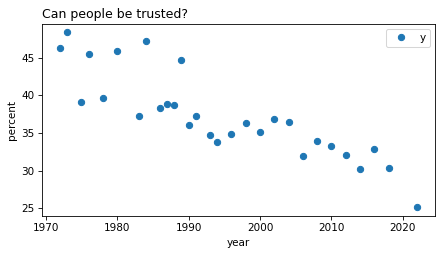

In [8]:
time_series = gss.groupby("year")["y"].mean() * 100
time_series.plot(style="o")
decorate(ylabel="percent", title="Can people be trusted?")

Sadly, levels of trust have been declining in the US for decades.

## Who is most trusting?

Who do you think is most trusting, Democrats, Republicans, or independents?
To find out, we'll use another [GSS variable](https://gssdataexplorer.norc.org/variables/141/vshow), which contains responses to this question:

> Generally speaking, do you usually think of yourself as a Republican, Democrat, Independent, or what?

```
0	Strong democrat
1	Not very strong democrat	
2	Independent, close to democrat	
3	Independent (neither, no response)	
4	Independent, close to republican	
5	Not very strong republican	
6	Strong republican
7	Other party
```

To simplify the analysis, we'll consider just three groups, Democrats (strong or not), Independent (leaning either way) and Republican (strong or not).

In [9]:
party_map = {
    0: 0,
    1: 0,
    2: 1,
    3: 1,
    4: 1,
    5: 2,
    6: 2,
    7: np.nan,
}

gss["partyid3"] = gss["partyid"].replace(party_map)
value_counts(gss["partyid3"])

,counts
values,
0.0,25439
1.0,26705
2.0,18338
NaN,1908


Well use this dictionary to map from codes to names.

In [10]:
party_names = {
    0: "Democrat",
    1: "Independent",
    2: "Republican",
}

The following table shows how the percentages in each group have changed over time.

In [11]:
table = (
    gss.pivot_table(index="year", columns="partyid3", values="y", aggfunc="mean")
).rename(columns=party_names) * 100

table.iloc[:10]

partyid3,Democrat,Independent,Republican
year,,,
1972,41.055341,48.325359,59.146341
1973,43.001686,49.295775,59.292035
1975,33.571429,40.525328,44.623656
1976,41.401274,44.383057,55.974843
1978,34.542587,44.649446,41.087613
1980,44.144144,44.878957,49.722222
1983,30.000000,41.403509,45.679012
1984,42.407407,48.098859,52.162162
1986,32.342657,37.894737,47.783251


Here's what the columns look like as time series.

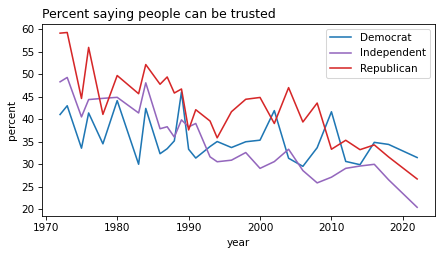

In [12]:
colors = ["C0", "C4", "C3"]
table.plot(color=colors)
decorate(ylabel="percent", title="Percent saying people can be trusted")

It looks like Republicans were the most trusting group, historically, but that might be changing.

## Logistic Regression

We'll use logistic regression to model changes in these responses over time and differences between groups.

The fundamental idea of logistic regression is that each observation unit -- like a survey respondent -- has some latent propensity to choose one of two options, and we assume:

* The latent propensities, `z[i]`, are a linear function of explanatory variables.

* The probability a respondent chooses a particular option is `expit(z[i])`.

Where `expit` is the function that maps from log-odds to probability (defined in `scipy.special`, also available from PyMC as `pm.math.sigmoid`).

As a first example, we'll make a model with `year` as an explanatory variable, so we'll assume

```
z = alpha + beta * year
```

In a minute we'll see how to represent this model in PyMC, but first let's prepare the data.
We'll select the rows with valid data for the response variable and `year`.

In [13]:
data = gss.dropna(subset=["y", "year"])
data.shape

(42639, 64)

And we'll extract the values as NumPy arrays.

In [14]:
y = data["y"].to_numpy()
year = data["year"].to_numpy()

We'll shift `year` so it's centered at its mean (and we'll see why later).

In [15]:
year_shift = data["year"].mean()
year = year - year_shift

Now here's the key idea of PyMC (and MCMC in general): if you can describe the data-generating process, the sampler can generate a sample from the posterior distribution of the parameters.

In [16]:
# Fill this in

with pm.Model() as logistic_model:

    # TODO: Choose priors for alpha and beta
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)

    # TODO: Define the linear predictor 
    z = 0

    # TODO: Apply the sigmoid function to get probabilities
    p = 0

    # TODO: Define the likelihood using a Bernoulli distribution
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

In [17]:
# Solution

with pm.Model() as logistic_model:

    # Priors for intercept and slope
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 1)

    # Linear predictor (log-odds)
    z = alpha + beta * year

    # The inverse logit function is called sigma
    p = pm.math.sigmoid(z)

    # Bernoulli likelihood with logit link
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

Objects created in the context manager are registered as elements of the model.
Here's a graphical representation of the model.

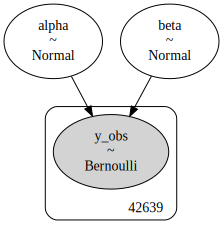

In [18]:
pm.model_to_graphviz(logistic_model)

## The posterior distribution

The function that samples from the posterior distribution is called `sample`.

```
with logistic_model:
    idata = pm.sample(draws=500, tune=500)
```

`draw` indicates the number of samples we want from each chain.
`tune` is the number of samples used to tune the chains before we start saving values.

For the workshop, we'll use the following function, which loads the results if they are already saved, or runs the sampler otherwise.

In [19]:
filename = "logistic_model_idata.nc"
idata = load_idata_or_sample(logistic_model, filename, draws=500, tune=500)

Loaded idata from logistic_model_idata.nc


The result is an [ArViz `InferenceData` object](https://python.arviz.org/en/stable/api/inference_data.html), which contains several groups of data stored as [xarray `DataSet` objects](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).

In [20]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

ArViz provides a variety of functions for processing and visualizing the results.
In this example, the primary thing we're interested in is the posterior distributions of the coefficients `alpha` and `beta`.

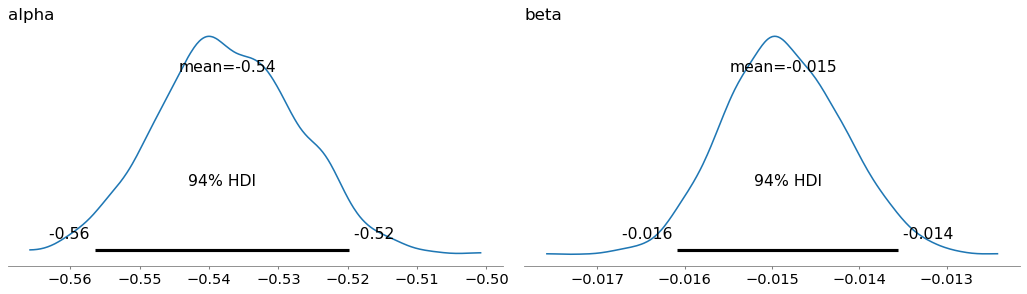

In [21]:
az.plot_posterior(idata)
decorate()

## Comparing Prior with Posterior

To see what we learned from the data, we can compare the prior and posterior distributions of the coefficents.
`sample_prior_predictive` runs the model forward to generate samples from the prior distribution (and the prior predictive, which we'll talk about later).

In [22]:
with logistic_model:
    idata_prior = pm.sample_prior_predictive(draws=1000)

Sampling: [alpha, beta, y_obs]


The result is another `InferenceData` object.
It will be convenient to put all of the samples in one object.

In [23]:
idata.extend(idata_prior)

Now we can compare the prior and posterior distributions.

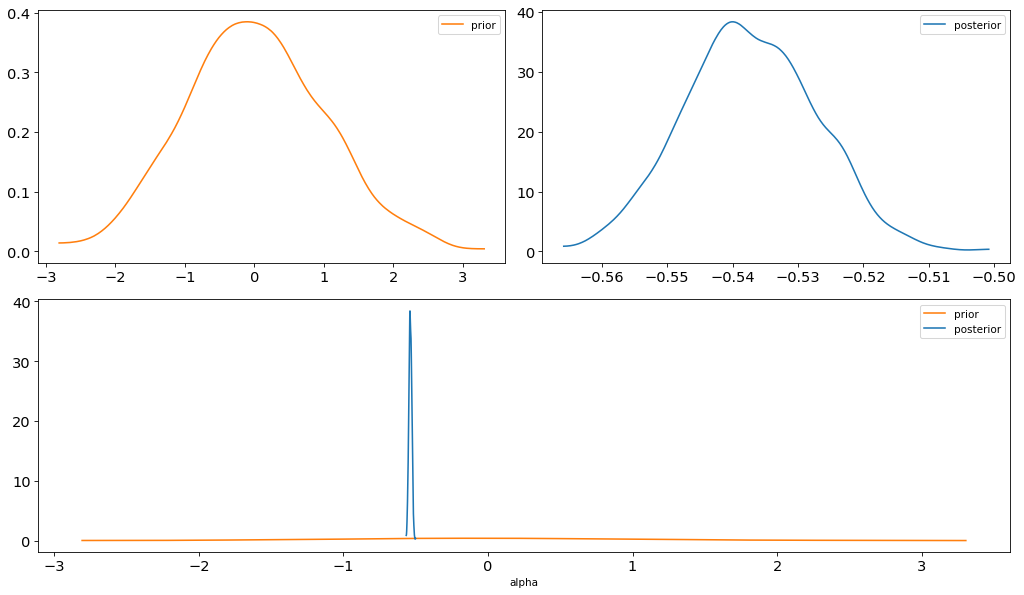

In [24]:
az.plot_dist_comparison(idata, var_names=["alpha"])
decorate()

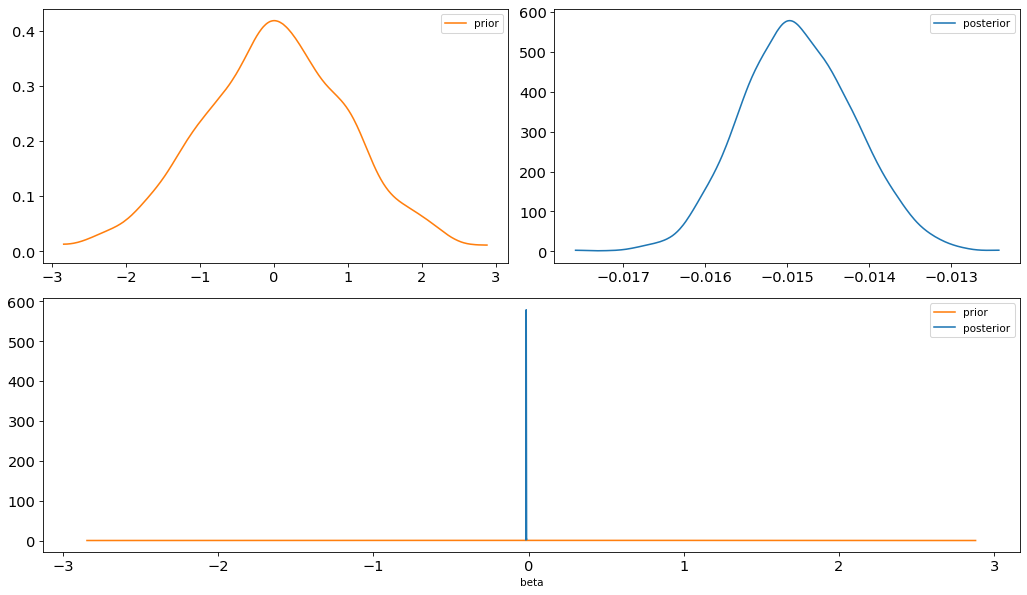

In [25]:
az.plot_dist_comparison(idata, var_names=["beta"])
decorate()

Looking at the posterior distributions of `alpha` and `beta`, we can see that they fall comfortably within the prior distributions of these parameters, which means that the priors didn't have much effect on the results.

As an experiment, try increasing or decreasing `sigma_prior` and see what effect it has on the posterior distributions.

## Sampling diagnostics

After sampling, we want to check that the process worked well — meaning:

* All chains have effectively explored the posterior distribution, and

* Successive draws within each chain are only weakly correlated (each draw should provide mostly new information).

We can check these properties visually using `plot_trace`:

*    On the left, the distribution from each chain should look similar — this is evidence that the chains all converged to the same region of the posterior.

*    On the right, the sequence of draws within each chain should look like uncorrelated noise (sometimes called "hairy caterpillars"). It shouldn't look like a random walk and there shouldn't be flat spots, which would suggest the chain got stuck.

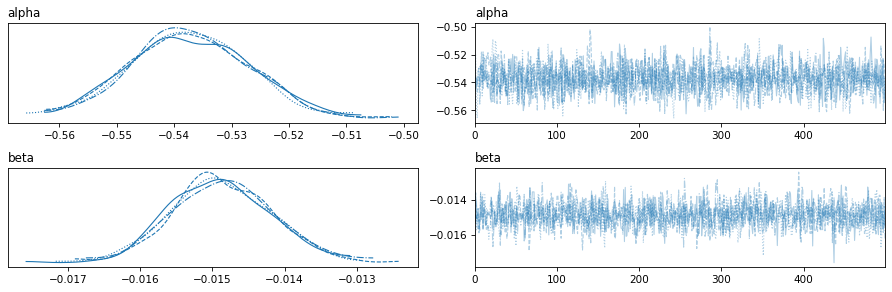

In [26]:
az.plot_trace(idata, var_names=["alpha", "beta"])
decorate()

To check these properties numerically, we can look at two key summary statistics: ESS and r-hat.

*    r-hat quantifies the difference between chains. If all chains converged to the same posterior distribution, r-hat should be close to 1. If the chains are exploring different regions, r-hat will be larger than 1, indicating failure to converge.

*    Effective Sample Size (ESS) tells us how much independent information the draws actually contribute. If successive values within a chain are highly correlated, the chain isn’t exploring the posterior efficiently, and ESS will be smaller than the total number of draws.

In [27]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.537,0.010,-0.556,-0.520,0.0,0.0,2109.0,1449.0,1.0
beta,-0.015,0.001,-0.016,-0.014,0.0,0.0,2010.0,1485.0,1.0


## Generating predictions

There are two ways to generate predictions:

* We can use the results from PyMC to compute our own predictions.

* We can use the PyMC model.

With this example, we'll demonstrate the first way.

First, we'll extract the samples of the coefficients from `idata` and convert them to NumPy arrays.

In [28]:
# Collect posterior draws of alpha and beta
samples = az.extract(idata, var_names=["alpha", "beta"], num_samples=100)

alphas = samples["alpha"].to_numpy()
alphas.shape

(100,)

In [29]:
betas = samples["beta"].to_numpy()
betas.shape

(100,)

Here's the range of years we'll predict.

In [30]:
year_range = np.arange(1970, 2031)
year_centered = year_range - year_shift

To generate predictions, we pretty much reimplement the model in NumPy.

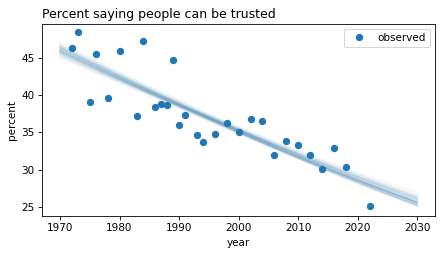

In [31]:
from scipy.special import expit

for alpha, beta in zip(alphas, betas):
    zs = alpha + beta * year_centered
    probs = expit(zs) * 100
    plt.plot(year_range, probs, color="C0", alpha=0.02)

time_series.plot(style="o", label="observed")
decorate(ylabel="percent", title="Percent saying people can be trusted")

It looks like the model fits the data well, and makes a plausible projection for the future.

## Centering the Data

You might remember that we mean-centered the predictor, `years`.
Now here's why: because we centered `years`, the sampled slopes and intercepts are uncorrelated.

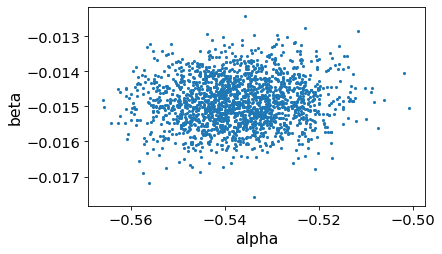

In [32]:
pm.plot_pair(idata, var_names=["alpha", "beta"])
decorate()

As an experiment, try:

* Set `year_shift=1970` and run the model again. You might get some warnings from the sampler, and `plot_pair` will show that the alphas and betas are correlated. The not-quite-centered predictor stretches the shape of the joint posterior distribution and makes it harder to sample efficiently.

* Set `year_shift=0` and run the model again. With the predictor completely uncentered, the joint posterior distribution is so stretched that the sampler diverges frequently -- and basically fails.

Without centering, the intercept represents the log-odds of the outcome when `year=0`, which is way outside the range of the data.
This forces the intercept and slope to compensate for each other — if the slope increases, the intercept must decrease to hit the same observed points.

As a general rule, it's a good idea to center continuous predictors in Bayesian regression models.

## Categorical predictors

Now let's add political party as a predictor.

In [33]:
value_counts(gss["partyid3"])

,counts
values,
0.0,25439
1.0,26705
2.0,18338
NaN,1908


To prepare the data, we'll select observations where all the variables in the model are valid.

In [34]:
data = gss.dropna(subset=["y", "year", "partyid3"])
data.shape

(41605, 64)

And again we'll center the years and convert all data to NumPy arrays.

In [35]:
y = data["y"].to_numpy()

year = data["year"].to_numpy()
year_shift = data["year"].mean()
year = year - year_shift

partyid3 = data["partyid3"].astype(int).to_numpy()

This version of the model adds a separate intercept for each group, but still has a single coefficient for the age effect.



In [36]:
# Modify this

with pm.Model() as logistic_model2:

    # Priors for intercept and slope
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 1)

    # Linear predictor (log-odds)
    z = alpha + beta * year

    # The inverse logit function is called sigma
    p = pm.math.sigmoid(z)

    # Bernoulli likelihood with logit link
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

In [37]:
# Solution

with pm.Model() as logistic_model2:

    # Party-specific intercepts (one for each group)
    alpha = pm.Normal("alpha", 0, 1, shape=3)

    # Shared slope for year (assuming effect of year is the same across parties)
    beta = pm.Normal("beta", 0, 1)

    # Linear predictor (log-odds)
    z = alpha[partyid3] + beta * year

    # Compute and save the probabilities
    p = pm.math.sigmoid(z)

    # Bernoulli likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

Here's the graph representation of the model.

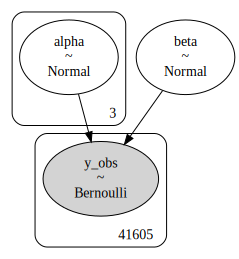

In [38]:
pm.model_to_graphviz(logistic_model2)

And here's how we run the sampler.

In [39]:
filename = 'logistic_model2_idata.nc'
idata2 = load_idata_or_sample(logistic_model2, filename, draws=500, tune=500)

Loaded idata from logistic_model2_idata.nc


Here are the trace plots.

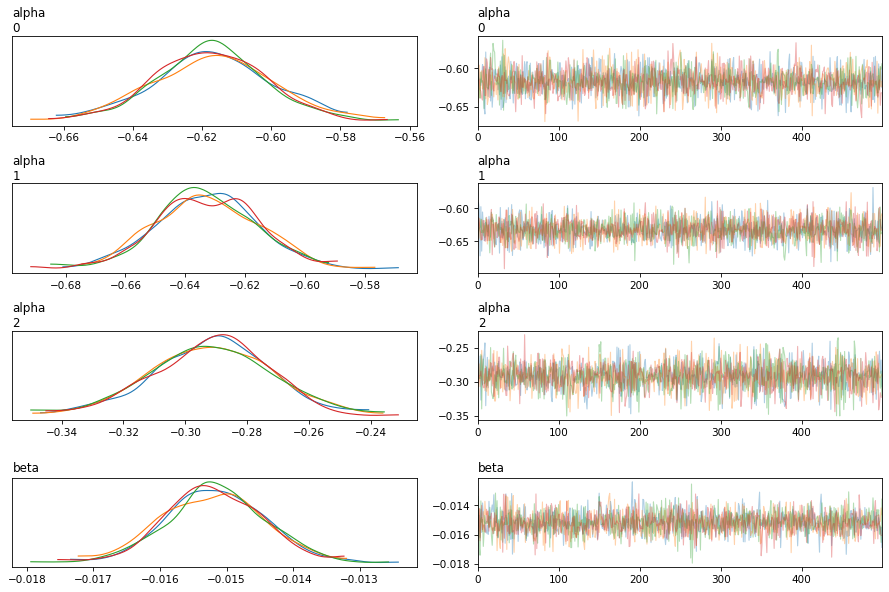

In [40]:
az.plot_trace(idata2, compact=False, var_names=["alpha", "beta"])
decorate()

And the diagnostic statistics.

In [41]:
pm.summary(idata2, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.617,0.017,-0.647,-0.584,0.0,0.0,2833.0,1574.0,1.01
alpha[1],-0.633,0.017,-0.661,-0.600,0.0,0.0,4295.0,1757.0,1.00
alpha[2],-0.292,0.019,-0.329,-0.256,0.0,0.0,2889.0,1385.0,1.00
beta,-0.015,0.001,-0.017,-0.014,0.0,0.0,2860.0,1791.0,1.00


Here are the posteriors.

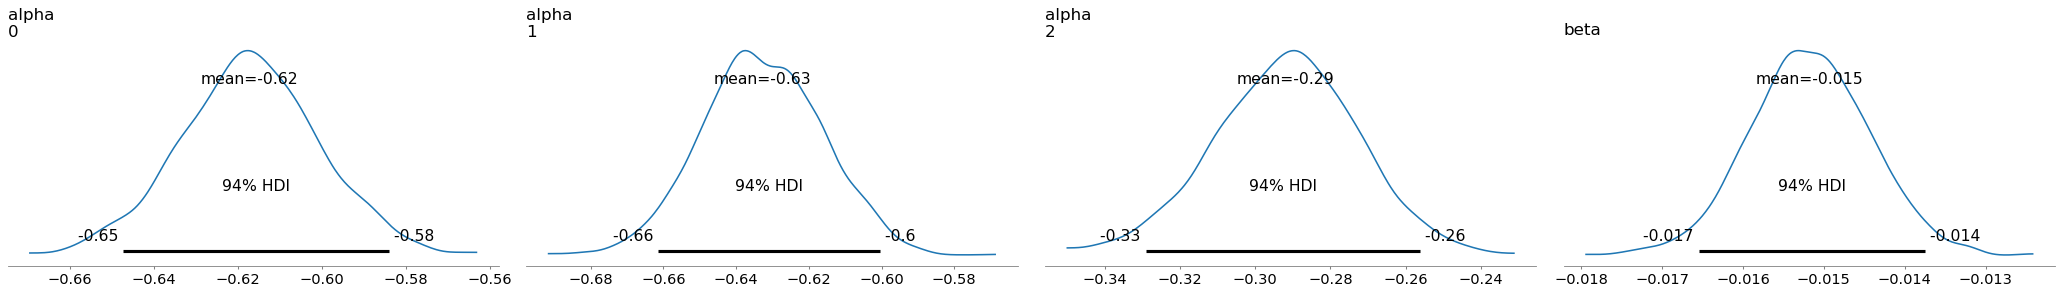

In [42]:
az.plot_posterior(idata2)
decorate()

## Viewing the Results

In [43]:
# Collect posterior draws of alpha and beta
samples = az.extract(idata2, var_names=["alpha", "beta"], num_samples=100)

alphas = samples["alpha"].to_numpy()
alphas.shape

(3, 100)

In [44]:
betas = samples["beta"].to_numpy()
betas.shape

(100,)

Here's the range of years we'll predict.

In [45]:
year_range = np.arange(1970, 2031)
year_centered = year_range - year_shift

Now we can plot the results for the three groups.

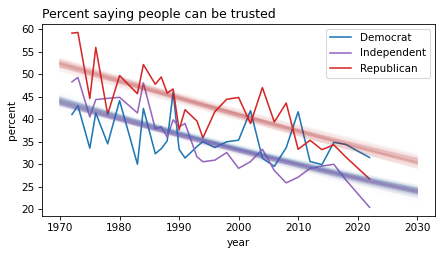

In [46]:
table.plot(color=colors)

for i in range(3):
    for alpha, beta in zip(alphas[i], betas):
        logits = alpha + beta * year_centered
        probs = expit(logits) * 100
        plt.plot(year_range, probs, color=colors[i], alpha=0.02)

decorate(ylabel="percent", title="Percent saying people can be trusted")

The posterior distributions of `p` overlap for the Democrat and Independent groups, but the distribution for Republicans is notably different.

Based on these results, we can say with some confidence that Republicans are more likely to say people can be trusted -- at least under the assumption that the changes over time are well modeled by the logistic regression model.

## Let the Model Do the Work

It might seem silly that we have to implement the model twice, once in PyMC to generate the posterior distribution, and once in NumPy to interpret the results.

It is possible -- and often desirable -- to make the PyMC model do the work, but for that we'll need two additional features:

* `Data`, which makes the input data part of the model so we can modify it to make out-of-sample predictions, and

* `Deterministic`, which saves the result of intermediate calculations as part of the `InferenceData`.

Here's the augmented version of the previous model.

In [47]:
with pm.Model() as logistic_model3:
    
    # add the predictors to the model as mutable Data
    year_pt = pm.Data("year", year)
    partyid3_pt = pm.Data("partyid3", partyid3)

    # Party-specific intercepts (one for each group)
    alpha = pm.Normal("alpha", 0, 1, shape=3)

    # Shared slope for year (assuming effect of year is the same across parties)
    beta = pm.Normal("beta", 0, 1)

    # Linear predictor (log-odds)
    z = alpha[partyid3_pt] + beta * year_pt

    # Compute and save the probabilities
    p = pm.Deterministic("p", pm.math.sigmoid(z))

    # Bernoulli likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

Here's the graph representation.

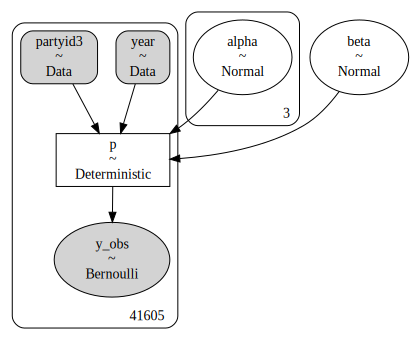

In [48]:
pm.model_to_graphviz(logistic_model3)

And here's how we run the sampler.

In [49]:
filename = 'logistic_model3_idata.nc'
idata3 = load_idata_or_sample(logistic_model3, filename, draws=500, tune=500)

Loaded idata from logistic_model3_idata.nc


Everything marked as `Deterministic` gets saved in the `idata`.

In [50]:
idata3

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Now to generate predictions, we can use the PyMC model directly.
We'll use:

* `set_data` to replace the data used during sampling with the values of `partyid3` and `year` we want to use for prediction, and

* `compute_deterministics` to compute the values of `p`, conditioned on the posterior distributions of `alpha` and `beta`.

In [51]:
probabilities = {}

with logistic_model3:
    for key, party_name in party_names.items():
        # Assign covariates to compute the posterior distributions of
        pm.set_data(
            {
                "partyid3": np.tile(key, len(year_centered)),
                "year": year_centered,
            }
        )

        # Compute the posterior predictive
        idata = pm.compute_deterministics(idata3['posterior'])

        probabilities[party_name] = az.extract(idata, num_samples=100)["p"]

Output()

Output()

Output()

Here's what the results look like.

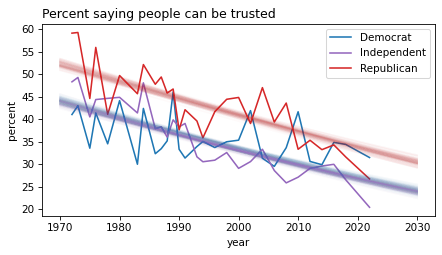

In [52]:
# Plot the original data
table.plot(color=colors)

# Plot posterior draws for each party affiliation
for key, party_name in party_names.items():
    ps = probabilities[party_name].to_numpy() * 100
    plt.plot(year_range, ps, color=colors[key], alpha=0.02)

decorate(ylabel="percent", title="Percent saying people can be trusted")

Using the PyMC model to generate predictions avoids implementing the model twice, and guarantees that the model and the predictions are consistent.
The drawbacks are:

* Adding `Data` and `Deterministic` can make the model code harder to read.

* Saving the `Data` and `Deterministic` variables makes the `InferenceData` larger.